# "PyMC v4 with labeled coords and dims"
> "Go even crazier with your virtual label-maker!"

- toc: true 
- author: Oriol Abril
- badges: true
- categories: [python, arviz, pymc, xarray]
- tags: [data storage, arviz converters]
- image: images/nb/labeled_arys.png
- twitter_large_image: true


In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import aesara.tensor as at

rng = np.random.default_rng()

In [2]:
#hide
# use text display to keep blog fast and responsive, 
# do not execute this cell when running the code
import xarray as xr
xr.set_options(display_style="text");

In [3]:
az.style.use("arviz-darkgrid")

## For the :heart: of labeled arrays
For all of us who love labeled arrays, [PyMC 3.9.0](https://github.com/pymc-devs/pymc3/blob/master/RELEASE-NOTES.md#pymc3-390-16-june-2020) came with some amazing news: support for using coordinate and dimension names to specify the shapes of variables in a `pm.Model`. This was already good news, but now, 2 years later, the integration between ArviZ and PyMC has improved even more.

Therefore, I decided to post and updated version of [my original blog post](https://oriolabrilpla.cat/python/arviz/pymc3/xarray/2020/09/22/pymc3-arviz.html) using version 3.x of PyMC now using
version 4.x of PyMC (currently in beta release).

This post will focus on using PyMC coords, dims and dims without coordinate values, and explain the conversion of traces and models to [`InferenceData`](https://python.arviz.org/en/latest/getting_started/XarrayforArviZ.html). Here are two resources to [learn about working with `InferenceData`](https://python.arviz.org/en/latest/getting_started/WorkingWithInferenceData.html) on ArviZ docs and to see `InferenceData` in action in the famous [radon example](https://docs.pymc.io/projects/examples/en/latest/case_studies/multilevel_modeling.html) on PyMC examples website.

We will use an example based approach and use models from the [example gallery](https://docs.pymc.io/projects/examples/en/latest/index.html) to illustrate how to use coords and dims within PyMC models.

## 1st example: rugby analytics
We will use an alternative parametrization of the same model used in the [rugby analytics example](https://docs.pymc.io/projects/examples/en/latest/case_studies/rugby_analytics.html) taking advantage of dims and coords. Here, we will use as observations a 2d matrix, whose rows are the matches and whose columns are the field: home and away.

The first step after preprocessing is to define the dimensions used by the model and their coordinates. In our case, we have 3 dimensions:

* `team`: each team will have its own offensive and defensive power
* `match`: an integer identifying the match. There are 6 teams who play twice against each other so we have `6*5*2=60` matches
* `field`: either home or away.

These coordinates are passed to `pm.Model` as a dict whose keys are dimension names and whose values are coordinate values. The dimensions can then be used when defining PyMC variables to indicate their shape.

In [4]:
df_rugby = pd.read_csv(pm.get_data('rugby.csv'), index_col=0)
home_idx, teams = pd.factorize(df_rugby["home_team"], sort=True)
away_idx, _ = pd.factorize(df_rugby["away_team"], sort=True)

In [5]:
coords = {
    "team": teams,
    "match": np.arange(60),
    "field": ["home", "away"],
}
with pm.Model(coords=coords) as rugby_model:
    # global model parameters
    home = pm.Flat('home')
    sd_att = pm.HalfStudentT('sd_att', nu=3, sigma=2.5)
    sd_def = pm.HalfStudentT('sd_def', nu=3, sigma=2.5)
    intercept = pm.Flat('intercept')

    # team-specific model parameters
    atts_star = pm.Normal("atts_star", mu=0, sigma=sd_att, dims="team")
    defs_star = pm.Normal("defs_star", mu=0, sigma=sd_def, dims="team")

    atts = pm.Deterministic('atts', atts_star - at.mean(atts_star), dims="team")
    defs = pm.Deterministic('defs', defs_star - at.mean(defs_star), dims="team")
    home_theta = at.exp(intercept + home + atts[home_idx] + defs[away_idx])
    away_theta = at.exp(intercept + atts[away_idx] + defs[home_idx])

    # likelihood of observed data
    pm.Poisson(
        'points', 
        mu=at.stack((home_theta, away_theta)).T, 
        observed=df_rugby[["home_score", "away_score"]],
        dims=("match", "field")
    )
    rugby_idata = pm.sample(1000, tune=1000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [home, sd_att, sd_def, intercept, atts_star, defs_star]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


We have now _defined_ the shapes of some of our variables (`atts_star` and `defs_star`) and _annotated_ the dimensions of some others. This is convenient and makes the code easier to understand, but we need to remember that in PyMC, dimensions are not inherited like in xarray. 

`atts` is `atts_star` minus a scalar value and it will be an array with the same shape as `atts_star` even without the `dims` argument. However, we need to _annotate_ the dimension if we want the output to have it.

In PyMC 4.x, the default return type of all sampling functions is `InferenceData`:

In [6]:
print(type(rugby_idata))

<class 'arviz.data.inference_data.InferenceData'>


## 2nd example: radon multilevel model
We will now use one of the many models in the [A Primer on Bayesian Methods for Multilevel Modeling](https://docs.pymc.io/projects/examples/en/latest/case_studies/multilevel_modeling.html) notebook to dive deeper into coords and dims functionality. We won't cover the model itself, it's already explained in the example notebook, we will explain in detail how are labeled coords and dims being used.

The code used to load and clean the data is hidden, click the button below to see it.

In [7]:
#collapse
srrs2 = pd.read_csv(pm.get_data("srrs2.dat"))
srrs2.columns = srrs2.columns.map(str.strip)
srrs_mn = srrs2[srrs2.state == "MN"].copy()

srrs_mn["fips"] = srrs_mn.stfips * 1000 + srrs_mn.cntyfips
cty = pd.read_csv(pm.get_data("cty.dat"))
cty_mn = cty[cty.st == "MN"].copy()
cty_mn["fips"] = 1000 * cty_mn.stfips + cty_mn.ctfips

srrs_mn = srrs_mn.merge(cty_mn[["fips", "Uppm"]], on="fips")
srrs_mn = srrs_mn.drop_duplicates(subset="idnum")
u = np.log(srrs_mn.Uppm).unique()

n = len(srrs_mn)
srrs_mn.county = srrs_mn.county.map(str.strip)
srrs_mn["county_code"], mn_counties = pd.factorize(srrs_mn.county)
srrs_mn["log_radon"] = np.log(srrs_mn.activity + 0.1)

The first step is again defining the dimensions and their coordinate values:

* `Level`: observations can correspond to the basement or the first floor
* `County`: each county has its own basement, intercept: `a`, and first floor, slope `b`, effects. Details are in the example notebook
* `param`: one of `a`, `b`
* `param2`: same as param, used for the covariance matrix because a variable can't have repeated dimensions

We will also use a dimension called `obs_id` for the `n` observations. In that case however, we don't care about the coordinate values and we are fine with them being an integer id. 

In PyMC v4, if you _annotate_ the dimensions of a `pm.Data`, `pm.ConstantData` or `pm.MutableData` object,
that dimension will be automatically created as dimension without coordinate values.

In [8]:
coords = {
    "level": ["basement", "floor"], 
    "county": mn_counties,
    "param": ["a", "b"],
    "param2": ["a", "b"],
}

We'll begin to define the model creating the indexing arrays that will implement the hierarchical model. We are using the `pm.Data` container to tell ArviZ to store the variables in the `constant_data` group. Moreover, `pm.Data` defines a theano shared variable, so its values can be modified in order to call `pm.sample_posterior_predictive` using different data. This is particularly interesting for regressions for example in order to generate predictions for the model.

In [9]:
with pm.Model(coords=coords) as radon_model:
    floor_idx = pm.MutableData("floor_idx", srrs_mn.floor, dims="obs_id")
    county_idx = pm.MutableData("county_idx", srrs_mn.county_code, dims="obs_id")

We'll also use a `LKJCholeskyCov`as prior for the covariance matrix. As you can see, it has no `dims` argument. We will have to indicate the dims that correspond to these variables with the `idata_kwargs` argument. `idata_kwargs` is used to indicate `pm.sample` what arguments to pass to [`pm.to_inference_data`](https://docs.pymc.io/en/latest/api/generated/pymc.to_inference_data.html), which (for now) is called internally to convert the trace to InferenceData.

In [10]:
with radon_model:
    sd_dist = pm.Exponential.dist(0.5)
    a = pm.Normal("a", mu=0.0, sigma=5.0)
    b = pm.Normal("b", mu=0.0, sigma=1.0)
    z = pm.Normal("z", 0.0, 1.0, dims=("param", "county"))
    
    chol, corr, stds = pm.LKJCholeskyCov(
        "chol", n=2, eta=2.0, sd_dist=sd_dist, compute_corr=True
    )

We now will store two intermediate results as variables. However, one is wrapped inside a `pm.Deterministic` whereas the other is not. Both are equally valid. `pm.Deterministic` tells PyMC to store that variable in the trace. Thus `pm.Deterministic` should only be used when we actively want to store the intermediate result. In our case, we want to store `ab_county` but not `theta`.

As we saw in the previous example, `pm.Deterministic` also has a `dims` argument, but it can only be used to _annotate_ the dimensions of that variable, not to _define_ an array variable from scalar parameters.

In [11]:
with radon_model:
    ab_county = pm.Deterministic("ab_county", at.dot(chol, z).T, dims=("county", "param"))
    theta = a + ab_county[county_idx, 0] + (b + ab_county[county_idx, 1]) * floor_idx

    sigma = pm.Exponential("sigma", 1.0)
    pm.Normal("y", theta, sigma=sigma, observed=srrs_mn.log_radon, dims="obs_id")

Finally we will call `pm.sample` and define the dimensions of the covariance matrix as `idata_kwargs`.

In [12]:
with radon_model:
    radon_idata = pm.sample(
        2000, tune=2000, target_accept=0.99, random_seed=75625,
        idata_kwargs={"dims": {"chol_stds": ["param"], "chol_corr": ["param", "param2"]}}
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, z, chol, sigma]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 403 seconds.


## There is life outside the posterior
The posterior is the center of Bayesian analysis but other quantities such as the prior or the posterior predictive are also crucial to an analysis workflow. We'll use a linear regression to quickly showcase some of the key steps in a Bayesian workflow: prior predictive checks, posterior sampling, posterior predictive checks (using LOO-PIT) and out of sample predictions.

We will start generating some simulated data (code hidden, click to expand) and defining the model. As it's a simple linear regression we'll only have scalar parameters, `a`, `b` and `sigma`.

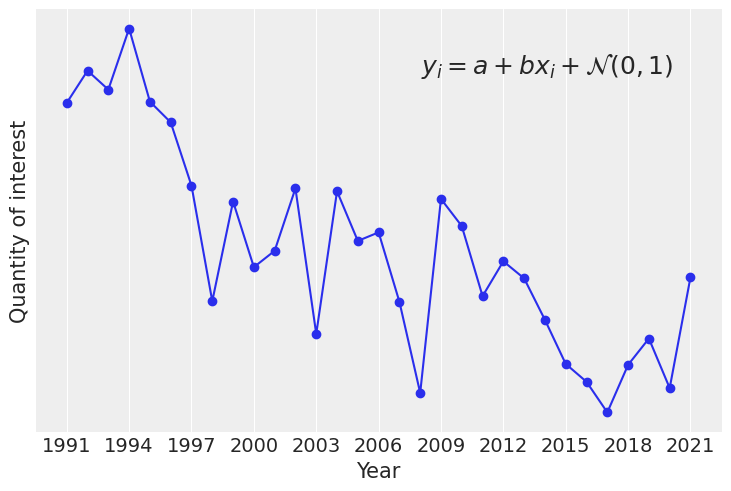

In [13]:
#collapse
a_true = 2
b_true = -0.4
x = np.linspace(0, 10, 31)
year = np.arange(2022-len(x), 2022)
y = a_true + b_true * x + rng.normal(size=len(x))

fig, ax = plt.subplots()
ax.plot(x, y, "o-")
ax.text(
    0.93, 0.9, r"$y_i = a + bx_i + \mathcal{N}(0,1)$", ha='right', va='top', transform=ax.transAxes, fontsize=18
)

ax.set_xticks(x[::3])
ax.set_xticklabels(year[::3])
ax.set_yticks([])
ax.set_xlabel("Year")
ax.set_ylabel("Quantity of interest");

In [44]:
coords = {"year": year}
with pm.Model(coords=coords) as linreg_model:
    # use x_ to avoid overwriting x previously defined as np.ndarray
    x_ = pm.MutableData("x", x, dims="year")
    
    a = pm.Normal("a", 0, 3)
    b = pm.Normal("b", 0, 2)
    sigma = pm.HalfNormal("sigma", 2)
    
    pm.Normal("y", a + b * x_, sigma, observed=y, dims="year")

We have now written a model in order to study our quantity of interest `y`. We have used everything we have seen so far, the `pm.Data` container and the labeled dims and coords. We will now simulate a workflow starting from prior predictive checks and finishing with predicting the values of our _quantity of interest_ in 2021 and 2022. 

### Priors
We start by sampling both prior and prior predictive with `pm.sample_prior_predictive`. In PyMC 4.x, this returns an `InferenceData` object with multiple groups depending on the data available, if provided, variables will have their corresponding dims and coords.

In [45]:
with linreg_model:
    linreg_idata = pm.sample_prior_predictive(700)

linreg_idata

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data
	> constant_data

We can now use `plot_ppc` to perform prior predictive checks for our model.

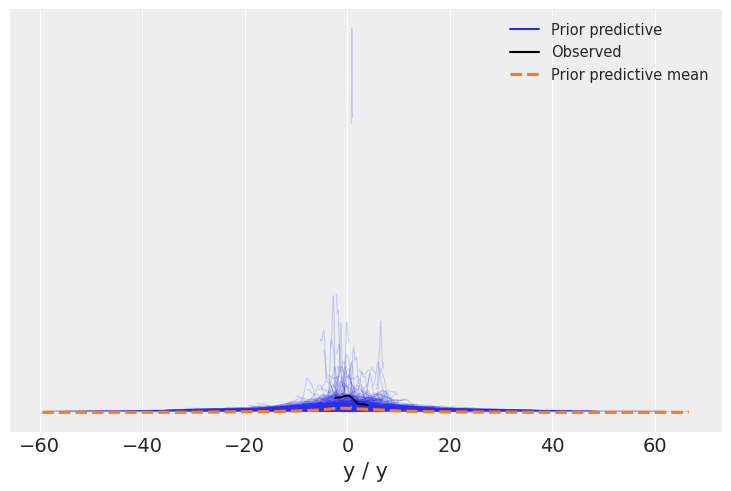

In [46]:
az.plot_ppc(linreg_idata, group="prior");

### Posterior
The next step will be computing the posterior. As we have seen, we can use `return_inferencedata` to get an `InferenceData` as a result of `pm.sample`. In this case however, we will store it as an auxiliary variable to then use `InferenceData.extend` and add the new groups to the `linreg_idata`. 

In [47]:
with linreg_model:
    idata_aux = pm.sample()
linreg_idata.extend(idata_aux)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
The acceptance probability does not match the target. It is 0.8893, but should be close to 0.8. Try to increase the number of tuning steps.


In [48]:
linreg_idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

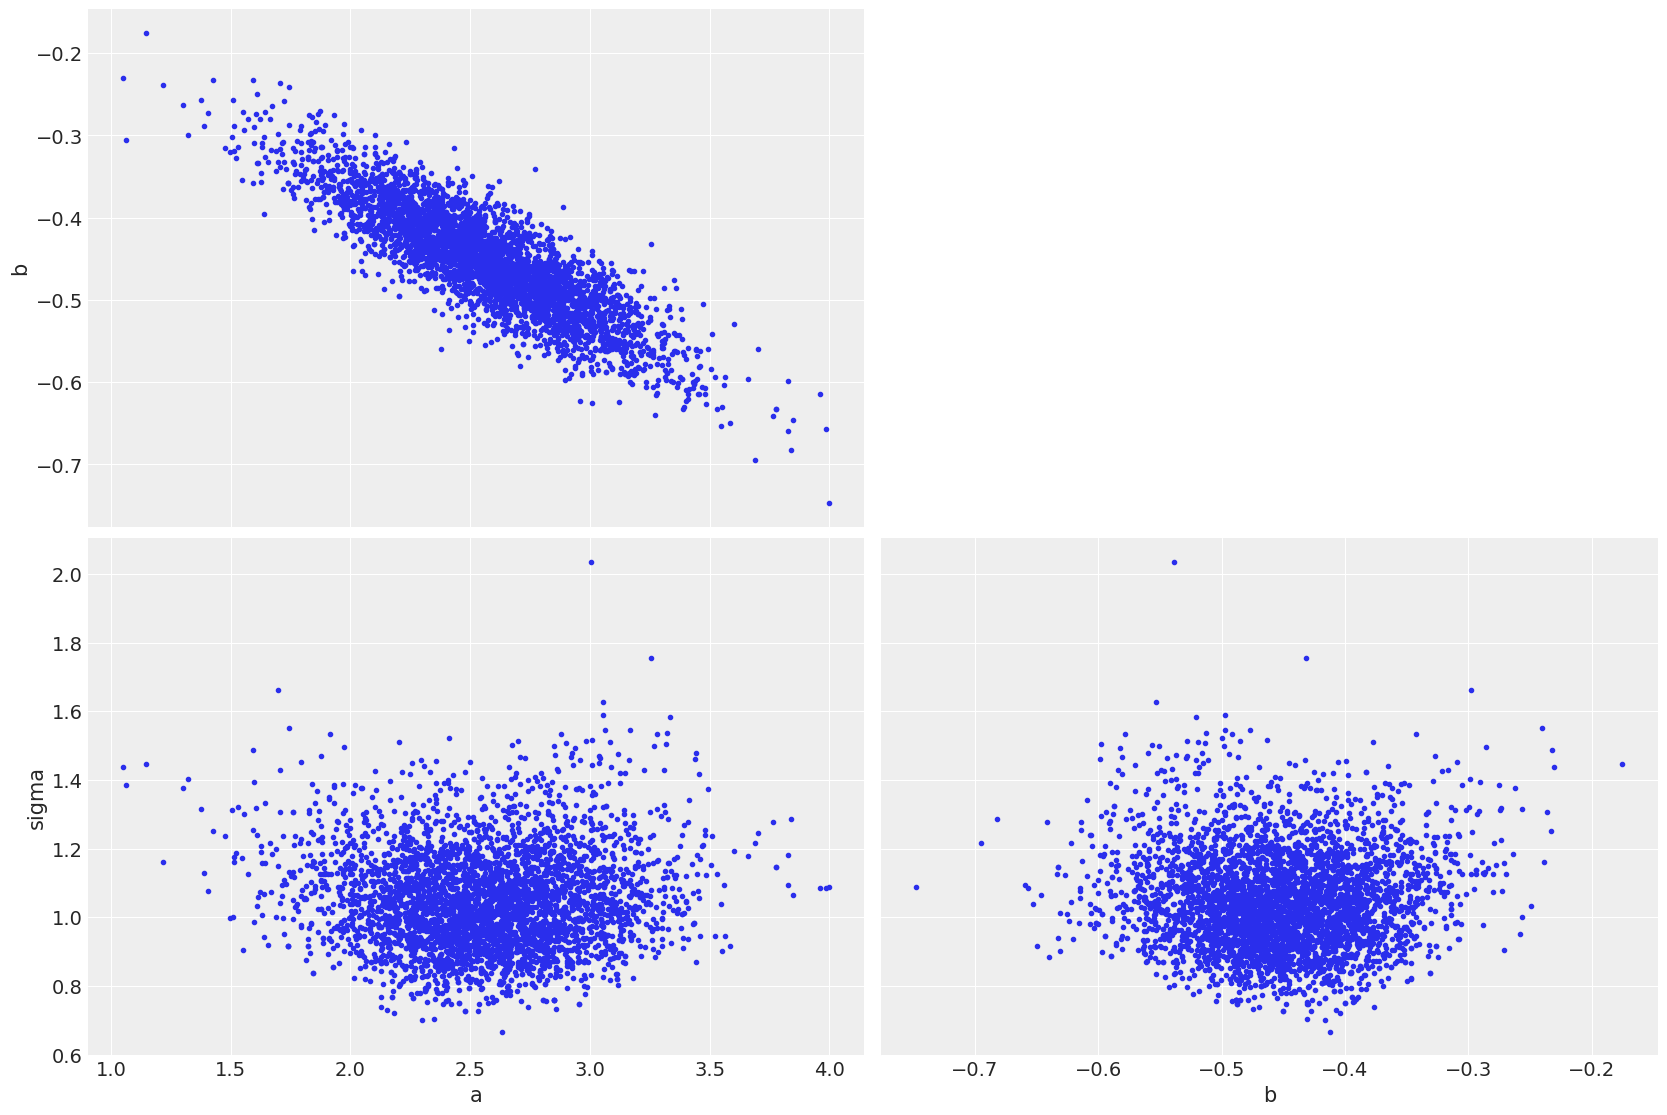

In [49]:
az.plot_pair(linreg_idata);

### Posterior predictive
Our third step will be to evaluate the posterior predictive at the observations so we can perform model checking with functions such as `plot_ppc` or `plot_loo_pit`. `sample_posterior_predictive` already returns an InferenceData, we will use the `extend_inferencedata` argument to indicate PyMC to add the new groups inplace.

This has two main advantages. `plot_loo_pit` requires both the `posterior_predictive` group, generated here and the `log_likelihood` group which was created in `pm.sample`. In addition, keeping all our data in a single `InferenceData` means we can store it as a netCDF and share a single file to allow reproducing the whole exploratory analysis of our model.

In [50]:
with linreg_model:
    pm.sample_posterior_predictive(linreg_idata, extend_inferencedata=True)

In [51]:
linreg_idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

We will now get to use `plot_loo_pit`, which as expected does not show any issues. To learn how to interpret those plots, you can read the [LOO-PIT tutorial](https://oriolabrilpla.cat/python/arviz/pymc3/2019/07/31/loo-pit-tutorial.html).

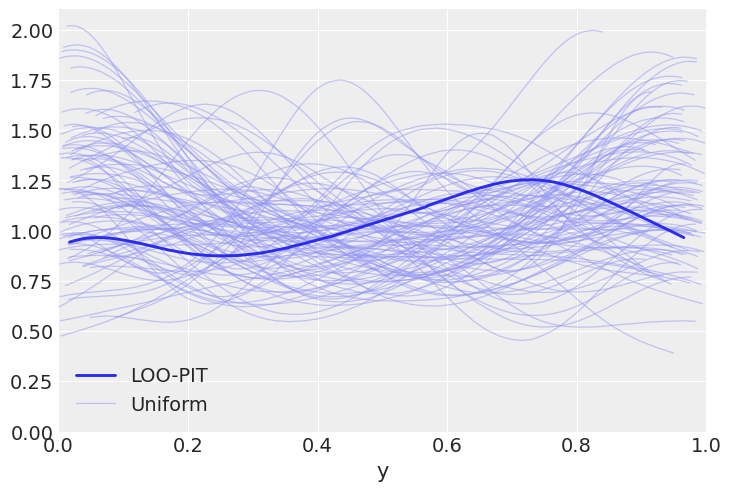

In [52]:
az.plot_loo_pit(linreg_idata, y="y");

### Predictions
Finally, our last step will be to get some predictions, which in this case is evaluating the posterior predictive at positions different than the observations. In the example below, we are evaluating our predictions at 2022 and 2023. To do so, we are using `pm.set_data` to modify the values of `x` to the ones that correspond to these two future years and to update the coordinate values of the `year` dimension.

Here we will use `predictions` and `extend_inferencedata` keywords. This will store these new samples in the `predictions` group and the modified `x` values in `predictions_constant_data` and add these groups inplace to our InferenceData object

In [53]:
with linreg_model:
    pm.set_data({"x": x[-1] + x[1:3]}, coords={"year": [2022, 2023]})
    pm.sample_posterior_predictive(linreg_idata, predictions=True, extend_inferencedata=True)

AttributeError: 'NoneType' object has no attribute 'inputs'

In [ ]:
linreg_idata

In [ ]:
az.plot_posterior(linreg_idata, group="predictions");

Package versions used to generate this post:

In [ ]:
#hide_input
%load_ext watermark
%watermark -n -u -v -iv -w

---
Comments are not enabled for this post, to inquiry further about the contents of the post, ask on [PyMC Discourse](https://discourse.pymc.io/). Feel free to tag me at [@OriolAbril](https://discourse.pymc.io/u/oriolabril)